In [1]:
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
%load_ext autoreload
%autoreload 2

import logging

logging.basicConfig(level=logging.INFO)

from abc import ABC, abstractmethod
from contextlib import AbstractContextManager
from typing import Protocol, runtime_checkable

import torch
from torch import Tensor, nn

from linodenet.lib import singular_triplet

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda-12.2'
/home/rscholz/.pyenv/versions/3.11.3/envs/kiwi/lib/python3.11/site-packages/torch/jit/annotations.py:310: UserWarning: TorchScript will treat type annotations of Tensor dtype-specific subtypes as if they are normal Tensors. dtype constraints are not enforced in compilation either.
  warnings.warn("TorchScript will treat type annotations of Tensor "


In [42]:
from torch.nn.functional import hardsigmoid, hardtanh

In [217]:
def s(x):
    return hardsigmoid(x * 3 + 1)


def g(x, a=1):
    zero = torch.zeros_like(x)
    ones = torch.ones_like(x)
    z = (1 + x / a) ** 2
    return torch.where(x >= -a, torch.minimum(z, ones), zero)


def g(x: Tensor, a: float = 3) -> Tensor:
    zero = torch.zeros_like(x)
    ones = torch.ones_like(x)
    y = torch.maximum(1 + x / a, zero)
    z = torch.minimum(y**2, ones)
    return z


def h(x, a=1):
    zero = torch.zeros_like(x)
    ones = torch.ones_like(x)
    z = (1 - 2 * x / a) * (1 + x / a) ** 2
    return torch.where(x >= -a, torch.where(x <= 0, z, ones), zero)


def h(x, a=1, b=0):
    zero = torch.zeros_like(x)
    ones = torch.ones_like(x)
    z = torch.maximum(1 + x / a, zero)
    z = torch.minimum(z**2, ones)

    y = torch.maximum(x * (1 - 2 * b / a) + b, zero)
    y = torch.minimum(y, x + b)
    return y * z - b * ones

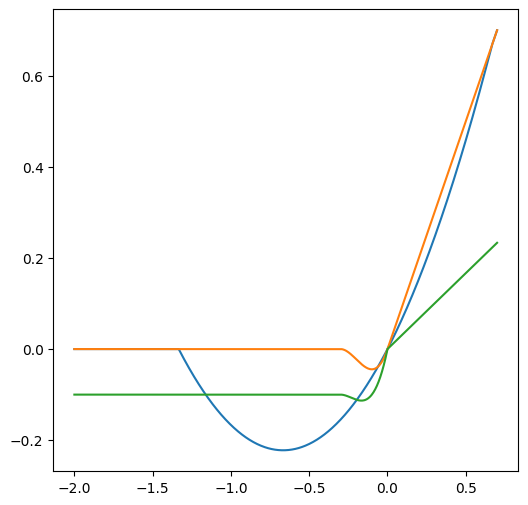

In [218]:
x = torch.linspace(-2, 0.7, 1000)
fig, ax = plt.subplots(figsize=(6, 6))

a, b = 0.3, 0.1
ax.plot(x, x * s(x))
ax.plot(x, x * g(x, a))
ax.plot(x, h(x, a, b))

In [126]:
plot x*hardsigmoid(x+1)

SyntaxError: invalid syntax (1267470311.py, line 1)

In [2]:
import torch
from torch import Tensor, nn
from torch.nn import functional as F
from torchinfo import summary

from linodenet.testing import test_model

In [22]:
class parametrize(nn.Module):
    weight: Tensor

    def __init__(self, weight: Tensor) -> None:
        super().__init__()
        self.weight = weight


class Foo(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        m, n = 4, 3
        self.weight = nn.Parameter(torch.empty(4, 3))
        self.weight = parametrize(self.weight).weight

    def forward(self, x: Tensor) -> Tensor:
        return F.linear(x, self.weight)

In [32]:
import torch
from torch import Tensor, jit, nn
from torch.nn.utils import parametrize as torch_parametrize

from linodenet.testing import test_model

In [33]:
    class Symmetric(nn.Module):
        def forward(self, X):
            return X.triu() + X.triu(1).transpose(-1, -2)


    model = nn.Linear(5, 5)

    torch_parametrize.register_parametrization(model, "weight", Symmetric())

    scripted = jit.script(model)

RecursiveScriptModule(
  original_name=ParametrizedLinear
  (parametrizations): RecursiveScriptModule(
    original_name=ModuleDict
    (weight): RecursiveScriptModule(
      original_name=ParametrizationList
      (0): RecursiveScriptModule(original_name=Symmetric)
    )
  )
)

In [38]:
inputs = torch.randn(7, 5)

try:
    scripted_outputs = scripted(inputs)
except Exception as exc:
    print(f"{type(exc)}")

<class 'torch.jit.Error'>


In [27]:
scripted_model = torch.jit.script(model)

RecursiveScriptModule(
  original_name=ParametrizedLinear
  (parametrizations): RecursiveScriptModule(
    original_name=ModuleDict
    (weight): RecursiveScriptModule(
      original_name=ParametrizationList
      (0): RecursiveScriptModule(original_name=Symmetric)
    )
  )
)

In [39]:
jit.script.Error

AttributeError: 'function' object has no attribute 'Error'

In [23]:
x = torch.randn(7, 3)

tensor([[-0.2711,  0.7241,  0.1464],
        [ 0.3789,  1.3858,  0.0362],
        [ 0.9076,  0.2596,  0.4451],
        [-0.6789, -0.6455, -0.3894],
        [ 2.0242,  0.1960, -2.1489],
        [-0.1782, -0.9948, -2.1928],
        [-1.1146,  1.4594, -0.4790]])

In [24]:
from copy import deepcopy

In [25]:
reference_model = nn.Linear(4, 3)
inputs = torch.randn(2, 4)
model = deepcopy(reference_model)
model.weight = parametrize(model.weight).weight

In [17]:
test_model(model, inputs=inputs, reference_model=reference_model, test_jit=True)

INFO:linodenet.testing._testing.Linear:>>> Reference model forward/backward ✔ 
INFO:linodenet.testing._testing.Linear:>>> Moved model/tensors to Device ✔ 
INFO:linodenet.testing._testing.Linear:>>> Forward ✔ 
INFO:linodenet.testing._testing.Linear:>>> Backward ✔ 
INFO:linodenet.testing._testing.Linear:>>> JIT-compilation ✔ 
INFO:linodenet.testing._testing.Linear@JIT:>>> Moved model/tensors to Device ✔ 
INFO:linodenet.testing._testing.Linear@JIT:>>> Forward ✔ 
INFO:linodenet.testing._testing.Linear@JIT:>>> Backward ✔ 
INFO:linodenet.testing._testing.Linear:>>> JIT-saving ✔ 
INFO:linodenet.testing._testing.Linear:>>> JIT-loading ✔ 
INFO:linodenet.testing._testing.Linear@JIT:>>> Moved model/tensors to Device ✔ 
INFO:linodenet.testing._testing.Linear@JIT:>>> Forward ✔ 
INFO:linodenet.testing._testing.Linear@JIT:>>> Backward ✔ 


In [13]:
summary(Foo())

Layer (type:depth-idx)                   Param #
Foo                                      12
Total params: 12
Trainable params: 12
Non-trainable params: 0

In [ ]:
class Foo

In [33]:
foo

In [2]:
import torch
from torch import jit, nn

from linodenet.testing import test_model

A = nn.Linear(4, 4)
P = nn.Linear(4, 4)
X = torch.randn(3, 4)
A.weight = P.weight
scripted = jit.script(A)
scripted(X)

test_model(A, inputs=X, test_jit=True)

INFO:linodenet.testing._testing.Linear:>>> Moved model/tensors to Device ✔ 
INFO:linodenet.testing._testing.Linear:>>> Forward ✔ 
INFO:linodenet.testing._testing.Linear:>>> Backward ✔ 
INFO:linodenet.testing._testing.Linear:>>> JIT-compilation ✔ 
INFO:linodenet.testing._testing.Linear@JIT:>>> Moved model/tensors to Device ✔ 
INFO:linodenet.testing._testing.Linear@JIT:>>> Forward ✔ 
INFO:linodenet.testing._testing.Linear@JIT:>>> Backward ✔ 
INFO:linodenet.testing._testing.Linear:>>> JIT-saving ✔ 
INFO:linodenet.testing._testing.Linear:>>> JIT-loading ✔ 
INFO:linodenet.testing._testing.Linear@JIT:>>> Moved model/tensors to Device ✔ 
INFO:linodenet.testing._testing.Linear@JIT:>>> Forward ✔ 
INFO:linodenet.testing._testing.Linear@JIT:>>> Backward ✔ 


In [ ]:
m, n = 5, 3
A = torch.randn(m, n)

In [ ]:
A.layout

In [ ]:
class Parametrization(nn.Module):
    """A parametrized tensor."""

    parametrized_tensors: dict[str, Tensor]
    cached_tensors: dict[str, Tensor]

    @torch.no_grad()
    def register_parametrization(self, name: str, param: nn.Parameter) -> None:
        """Register a parametrization."""
        if not isinstance(param, nn.Parameter):
            raise ValueError(f"Given tensor is not a nn.Parameter!")

        # create the cached tensor.
        self.register_cached_tensor(f"cached_{name}", torch.empty_like(param))

        # register the parametrization.
        self.parametrized_tensors[name] = param

    @torch.no_grad()
    def register_cached_tensor(self, name: str, tensor: Tensor) -> None:
        """Register a cached tensor."""
        if name in self.cached_tensors:
            raise ValueError(f"Cache with {name=!r} already registered!")
        if name in self.named_buffers():
            raise ValueError(f"Buffer with {name=!r} already taken!")

        self.register_buffer(name, tensor)
        self.cached_tensors[name] = getattr(self, name)

    def recompute_cache(self) -> None:
        # Compute the cached weight matrix
        new_tensors = self.forward()

        # copy the new tensors into the cache
        for key, tensor in new_tensors.items():
            self.cached_tensors[key].copy_(tensor)

    @torch.no_grad()
    def projection(self) -> None:
        # update the cached weight matrix
        self.recompute_cache()

        # copy the cached values into the parametrized tensors
        for key, tensor in self.parametrized_tensors.items():
            tensor.copy_(self.cached_tensors[key])

    def reset_cache(self) -> None:
        # apply projection step.
        self.projection()

        # reengage the autograd engine
        # detach() is necessary to avoid "Trying to backward through the graph a second time" error
        for key, tensor in self.cached_tensors.items():
            tensor.detach_()

        # recompute the cache
        # Note: we need the second run to set up the gradients
        self.recompute_cache()

    def reset_cache_expanded(self) -> None:
        # apply projection step.
        with torch.no_grad():
            # update the cached weight matrix
            new_tensors = self.forward()

            if new_tensors.keys() != self.cached_tensors.keys():
                raise ValueError(
                    f"{new_tensors.keys()=} != {self.cached_tensors.keys()=}"
                )

            # copy the new tensors into the cache
            for key, tensor in new_tensors.items():
                self.cached_tensors[key].copy_(tensor)

        # copy the cached values into the parametrized tensors
        for key, tensor in self.parametrized_tensors.items():
            tensor.copy_(self.cached_tensors[key])

        # reengage the autograd engine
        # detach() is necessary to avoid "Trying to backward through the graph a second time" error
        for key, tensor in self.cached_tensors.items():
            tensor.detach_()

        # recompute the cache
        # Note: we need the second run to set up the gradients
        # Compute the cached weight matrix
        new_tensors = self.forward()

        # copy the new tensors into the cache
        for key, tensor in new_tensors.items():
            self.cached_tensors[key].copy_(tensor)


class SpectralNormalization(Parametrization):
    """Spectral normalization."""

    # constants
    GAMMA: Tensor
    ONE: Tensor

    # cached
    u: Tensor
    v: Tensor
    sigma: Tensor

    # parametrized
    weight: Tensor

    def __init__(self, weight: nn.Parameter, /, gamma: float = 1.0) -> None:
        super().__init__()

        assert len(weight.shape) == 2
        m, n = weight.shape

        options = {
            "dtype": weight.dtype,
            "device": weight.device,
            "layout": weight.layout,
        }

        # parametrized and cached
        self.register_parametrization("weight", weight)
        self.register_cached_tensor("u", torch.empty(m, **options))
        self.register_cached_tensor("v", torch.empty(n, **options))
        self.register_cached_tensor("sigma", torch.empty(1, **options))

        # constants
        self.register_buffer("ONE", torch.empty(1, **options))
        self.register_buffer("GAMMA", torch.empty(gamma, **options))

    def forward(self) -> dict[str, Tensor]:
        sigma, u, v = singular_triplet(self.weight, u0=self.u, v0=self.v)
        gamma = torch.minimum(self.ONE, self.GAMMA / sigma)
        weight = gamma * self.weight
        return {"weight": weight, "u": u, "v": v, "sigma": sigma}


def reset_all_caches(module: nn.Module) -> None:
    """Reset all caches in a module."""
    for submodule in module.modules():
        if isinstance(submodule, ParametrizationABC):
            submodule.reset_cache()


class reset_caches(AbstractContextManager):
    """reset_caches context manager."""

    def __init__(self, module: nn.Module) -> None:
        self.module = module

    def __enter__(self):
        reset_all_caches(self.module)
        return self.module

    def __exit__(self, exc_type, exc_val, exc_tb):
        reset_all_caches(self.module)
        return False

tensor([[-0.9288,  0.0188, -1.2009, -0.3212],
        [ 0.0135, -1.1136,  0.8689,  0.0364],
        [ 0.4995, -0.8022,  1.0950,  0.1541]], grad_fn=<AddmmBackward0>)

INFO:linodenet.testing._testing.Linear:>>> Moved model/tensors to Device ✔ 
INFO:linodenet.testing._testing.Linear:>>> Forward ✔ 
INFO:linodenet.testing._testing.Linear:>>> Backward ✔ 
INFO:linodenet.testing._testing.Linear:>>> JIT-compilation ✔ 
INFO:linodenet.testing._testing.Linear@JIT:>>> Moved model/tensors to Device ✔ 
INFO:linodenet.testing._testing.Linear@JIT:>>> Forward ✔ 


AssertionError: 

In [14]:
next(t.device for t in A.parameters())

device(type='cpu')